In [1]:
%load_ext autoreload
%autoreload 2

# Full Country Analysis

## Setup

In [1]:
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from src.constants import DATA_PATH

run_name = "ukraine_full_inference"
PREDS_PATH = DATA_PATH / run_name / "buildings_preds.parquet"
assert PREDS_PATH.exists()

df_preds = pd.read_parquet(PREDS_PATH, engine="fastparquet")
df_preds.shape

(26564415, 31)

In [2]:
from src.utils.geo import load_ukraine_admin_polygons

adm1 = load_ukraine_admin_polygons(adm_level=1).rename({"admin_id": "adm1_id"}, axis=1).set_index("adm1_id")
adm2 = load_ukraine_admin_polygons(adm_level=2).rename({"admin_id": "adm2_id"}, axis=1).set_index("adm2_id")
adm3 = load_ukraine_admin_polygons(adm_level=3).rename({"admin_id": "adm3_id"}, axis=1).set_index("adm3_id")
d_adm = {i + 1: adm for i, adm in enumerate([adm1, adm2, adm3])}
adm1.shape, adm2.shape, adm3.shape

((27, 2), (139, 3), (1769, 4))

## Aggregate per admin region

In [3]:
adm_level = 3

In [5]:
# Condition to select destroyed buildings
threshold = 0.655
min_area = 50
post_dates_neg = ["2021-02-24", "2021-05-24", "2021-08-24", "2021-11-24"]
post_dates = [
    "2022-02-24",
    "2022-05-24",
    "2022-08-24",
    "2022-11-24",
    "2023-02-24",
    "2023-05-24",
    "2023-08-24",
    "2023-11-24",
]
cond_neg = (df_preds[post_dates_neg] < threshold * 255).all(axis=1)
cond_pos = (df_preds[post_dates] >= threshold * 255).any(axis=1)
_condition = cond_neg & cond_pos & (df_preds["area"] > min_area)

# Select destroyed buildings
df_destroyed = df_preds[_condition]
df_destroyed_adm = df_destroyed.groupby(f"adm{adm_level}_id").size()
df_destroyed_adm.name = "n_buildings_damaged"

# add geometry
df = gpd.GeoDataFrame(
    d_adm[adm_level][[f"ADM{adm_level}_EN", "geometry"]].join(df_destroyed_adm, how="left"), crs="EPSG:4326"
)
df.fillna(0, inplace=True)
df_adm_tot = df_preds[df_preds.area > min_area].groupby(f"adm{adm_level}_id").size()
df_adm_tot.name = "n_buildings"
df["n_buildings"] = df_adm_tot
df["perc_destroyed"] = 100 * df["n_buildings_damaged"] / df["n_buildings"]

In [6]:
# The 10 most destroyed regions
df.sort_values("perc_destroyed", ascending=False).head(10)

,ADM3_EN,geometry,n_buildings_damaged,n_buildings,perc_destroyed
adm3_id,,,,,
3_500,Bakhmutska,"MULTIPOLYGON (((38.27382 48.57514, 38.27511 48...",8547.0,20062,42.602931
3_504,Soledarska,"POLYGON ((38.28403 48.80433, 38.28318 48.80269...",3369.0,8738,38.555734
3_501,Zvanivska,"POLYGON ((38.22887 48.87903, 38.22887 48.87871...",702.0,1952,35.963115
3_956,Kolomyichyska,"POLYGON ((37.97458 49.61166, 37.97475 49.61150...",716.0,2459,29.117527
3_558,Marinska,"MULTIPOLYGON (((37.51572 48.05122, 37.51606 48...",4549.0,15660,29.048531
3_965,Popasnianska,"POLYGON ((38.46710 48.77726, 38.46735 48.77719...",2959.0,11801,25.074146
3_753,Malynivska,"POLYGON ((36.70013 47.73239, 36.70285 47.72115...",685.0,2751,24.900036
3_509,Vuhledarska,"POLYGON ((37.25572 47.86692, 37.25738 47.86668...",2290.0,9535,24.016780
3_561,Ocheretynska,"MULTIPOLYGON (((37.81759 48.36787, 37.81779 48...",3041.0,12854,23.658005


In [7]:
# The 10 most destroyed regions with more than 10k buildings
df[df.n_buildings > 10000].sort_values("perc_destroyed", ascending=False).head(10)

,ADM3_EN,geometry,n_buildings_damaged,n_buildings,perc_destroyed
adm3_id,,,,,
3_500,Bakhmutska,"MULTIPOLYGON (((38.27382 48.57514, 38.27511 48...",8547.0,20062,42.602931
3_558,Marinska,"MULTIPOLYGON (((37.51572 48.05122, 37.51606 48...",4549.0,15660,29.048531
3_965,Popasnianska,"POLYGON ((38.46710 48.77726, 38.46735 48.77719...",2959.0,11801,25.074146
3_561,Ocheretynska,"MULTIPOLYGON (((37.81759 48.36787, 37.81779 48...",3041.0,12854,23.658005
3_549,Mariupolska,"POLYGON ((37.57855 47.21971, 37.57999 47.21958...",13071.0,66891,19.540745
3_540,Lymanska,"POLYGON ((38.04324 49.15028, 38.04334 49.15057...",5232.0,30428,17.194689
3_1436,Iziumska,"MULTIPOLYGON (((37.40776 49.37125, 37.40806 49...",3248.0,22641,14.345656
3_966,Rubizhanska,"POLYGON ((38.47704 49.28308, 38.47613 49.27172...",1929.0,13574,14.210992
3_507,Velykonovosilkivska,"POLYGON ((37.07730 47.93337, 37.07725 47.93289...",1817.0,13068,13.904193


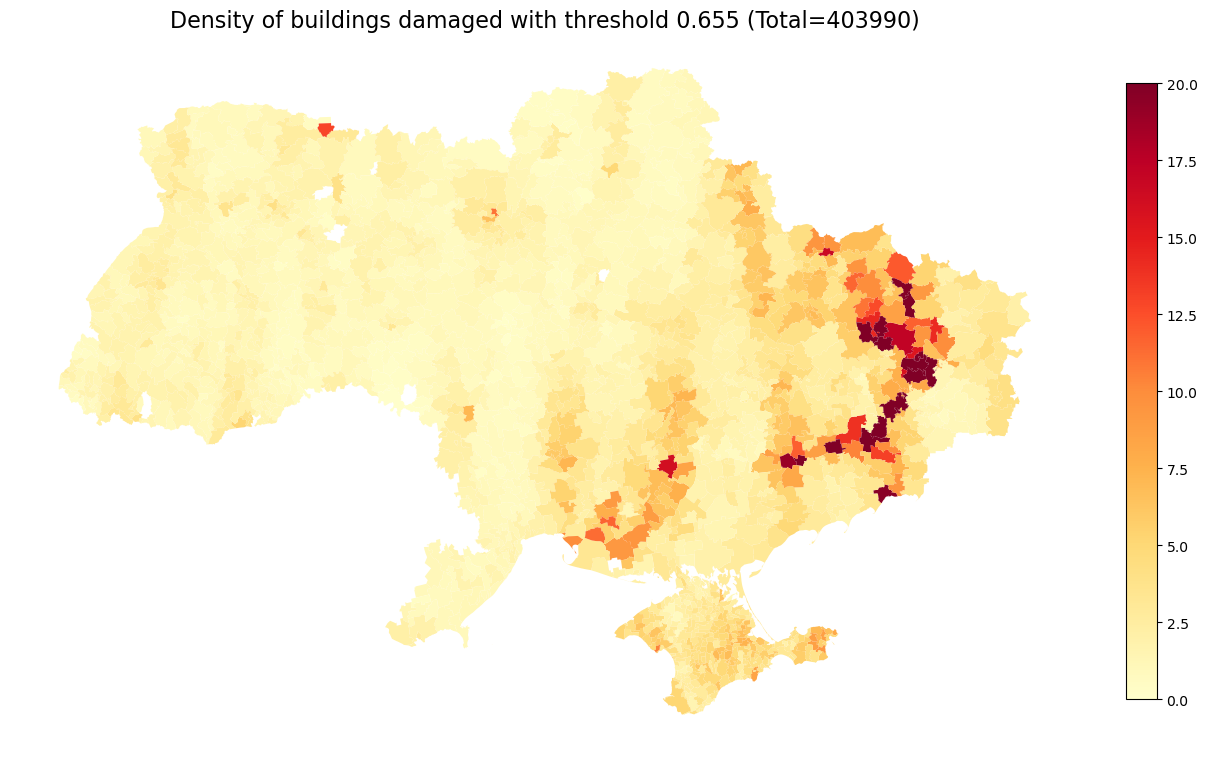

In [8]:
field_name = "perc_destroyed"
vmin = 0
vmax = 20

fig, ax = plt.subplots(figsize=(15, 10))
im = df[df[field_name] > vmin].plot(field_name, cmap="YlOrRd", vmin=vmin, vmax=vmax, ax=ax)
n_destroyed = df.n_buildings_damaged.sum()
title = f"Density of buildings damaged with threshold {threshold} (Total={int(n_destroyed)})"
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.8, fraction=0.04, pad=0.04)
ax.set_title(title, fontsize=16)
ax.set_axis_off()
plt.show()